<figure>
  <IMG src="figures/logo-esi-sba.png" WIDTH=300 height="100" ALIGN="right">
</figure>

# Practical Trainining Series on Modeling And Simulation   
*By Dr. Belkacem KHALDI (b.khaldi@esi-sba.dz)*

## Notebook 7: Modeling and Simulating Discrete-Event Systems
<figure>
  <IMG src="figures/ch7-des-fig1.png" WIDTH=400 height="400" ALIGN="right">
</figure>

In this Notebook you learn how to model and simulate Discerte-Event systems using simpy python library.
Discrete-Event Systems are a type of systems that are driven by discret-events. The state of such systems is changed whenever an event occures. The occurence of an event is mostely stochastic in time and therefore the  inter-arival events time is discret. 

### simpy
SimPy is a discrete-event simulation library. The behavior of active components (like vehicles, customers or messages) is modeled with processes. All processes live in an environment. They interact with the environment and with each other via events.

 First of all we will need the simpy python library to simulate such systens    

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install simpy
import simpy

### Our First Process
Let's simulate our first example which will be about a Customer visiting a Bank. We assume that the Bank is always full of customers and when the visitor arrives, he will stay just 10 minites there and then leave the Bank without even being served. We assume also that our customer will frequently visit the Bank each 30 minutes and he will alternately arrive and leave for a while. When he arrives (or leaves) the Bank, we will print and save both the current sate and simulation time. So, the customer switches between the states arriving and departure.

Mr. KHALDI Arrives at the Bank at 0
Mr. KHALDI leaves the Bank at 10
Mr. KHALDI Arrives at the Bank at 40
Mr. KHALDI leaves the Bank at 50
Mr. KHALDI Arrives at the Bank at 80
Mr. KHALDI leaves the Bank at 90


Text(0, 0.5, 'State')

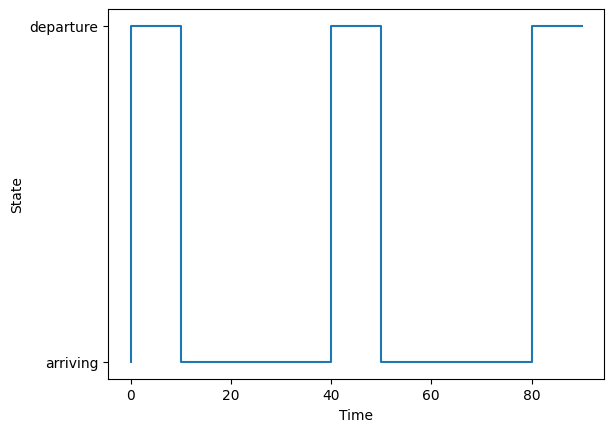

In [3]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt

arriving_duration = 10
departure_duration = 30
simulation_time=120
#A list for saving purposes
events=[]
#Define a customer process that requires a reference to an simpy.Environment (env) in order to create new events
def Customer(env,name):
    # To be runned in infinite loop. 
    while True:
        #Announcing the arriving state by printing a message and the current simulation time
        print('Mr. %s Arrives at the Bank at %d' % (name, env.now))
        #save the actual time and state 
        events.append([env.now,'arriving'])
        
        
        #Create a Timeout event and wait for the event to occur. in a given amount of time
        yield env.timeout(arriving_duration)
        
        
        #Announcing the departure state by printing a message and the current simulation time
        print('Mr. %s leaves the Bank at %d' % (name, env.now))
        #save the actual time and state 
        events.append([env.now,'departure'])
        
        #Create a Timeout event and wait for the event to occur. in a given amount of time
        yield env.timeout(departure_duration)
        
        
# create an instance of Simpy Environment. 
env = simpy.Environment()
#Passing env into our customer process function. 
#Started a process and added to the environment

env.process(Customer(env,'KHALDI'))
#start the simulation by calling run() and passing an end time to it.
env.run(until=simulation_time)

#Create a dataframe from list events and plot
df=pd.DataFrame(events, columns=['time','event'])
plt.step(df['time'],df['event'])
plt.xlabel('Time')
plt.ylabel('State')

### Challenge 1:
Recretae the above scenario by assuming now that the arriving and departure duration are stochastic (random).
#### Hint
Use randint from the random import library

Mr. KHALDI Arrives at the Bank at 0
Mr. KHALDI leaves the Bank at 0
Mr. KHALDI Arrives at the Bank at 8
Mr. KHALDI leaves the Bank at 16
Mr. KHALDI Arrives at the Bank at 49
Mr. KHALDI leaves the Bank at 66
Mr. KHALDI Arrives at the Bank at 80
Mr. KHALDI leaves the Bank at 105


Text(0, 0.5, 'State')

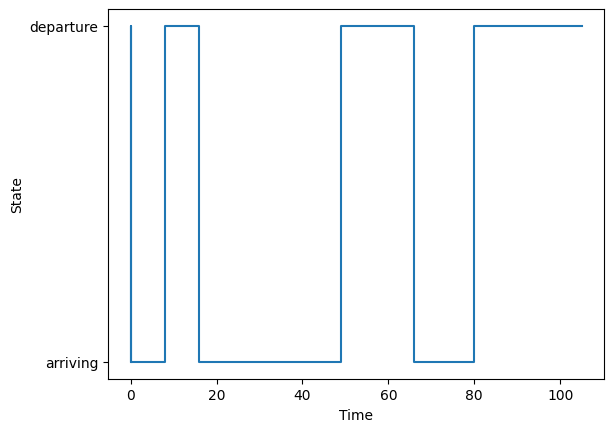

In [13]:
#your code here
import simpy
import pandas as pd
import matplotlib.pyplot as plt
import random

arriving_duration = random.randint(0, 50)
departure_duration = random.randint(0, 50)
simulation_time=120
#A list for saving purposes
events=[]
#Define a customer process that requires a reference to an simpy.Environment (env) in order to create new events
def Customer(env,name):
    # To be runned in infinite loop. 
    while True:
        #Announcing the arriving state by printing a message and the current simulation time
        print('Mr. %s Arrives at the Bank at %d' % (name, env.now))
        #save the actual time and state 
        events.append([env.now,'arriving'])
        
        
        #Create a Timeout event and wait for the event to occur. in a given amount of time
        yield env.timeout(random.randint(0, 50))
        
        
        #Announcing the departure state by printing a message and the current simulation time
        print('Mr. %s leaves the Bank at %d' % (name, env.now))
        #save the actual time and state 
        events.append([env.now,'departure'])
        
        #Create a Timeout event and wait for the event to occur. in a given amount of time
        yield env.timeout(random.randint(0, 50))
        
        
# create an instance of Simpy Environment. 
env = simpy.Environment()
#Passing env into our customer process function. 
#Started a process and added to the environment

env.process(Customer(env,'KHALDI'))
#start the simulation by calling run() and passing an end time to it.
env.run(until=simulation_time)

#Create a dataframe from list events and plot
df=pd.DataFrame(events, columns=['time','event'])
plt.step(df['time'],df['event'])
plt.xlabel('Time')
plt.ylabel('State')

## Our Second Process
Let's assume now that our Customer decides to wait for his service at the Bank. We assume that the Bank has one desk that serves all the cutomers with a Queue type notation (D/D/1). The arriver of a customer is set to be each 7 minutes and the time taken to serve a customer is set to be 5 minutes.
### Hint:
This system is of Queue Type Notation D/D/1 because:


In [1]:
"""
Bank example.

Covers:

- Waiting for other processes
- Resources: Resource

Scenario:
  A Bank has a limited number of service desks and defines
  a service processes that takes some (random) time.

  Customer processes arrive at the Bank at a random time. If one Service
  desk is available, they start serving the customer and wait for it
  to finish. If not, they wait until they  use one.

"""
import numpy.random as rnd
import simpy
import pandas as pd


RANDOM_SEED = 42
NUM_DESKS = 1  # Number of service desks in the Bank
SERVICETIME = 5      # Minutes it takes to serve a customer
T_INTER = 10       # Create a customer every ~10 minutes
SIM_TIME = 45     # Simulation time in minutes

events=[]

class Bank(object):
    """A Bank has a limited number of service desks (``NUM_DESKS``) to
    serve customers in parallel.

    Customers have to request one of the service desks. When they got one, they
    be served and wait for the agent to finish their request which 
    takes ``SERVICETIME`` minutes).

    """
    def __init__(self, env, num_desks, service_time):
        self.env = env
        self.desk = simpy.Resource(env, num_desks)
        self.serviceTime = service_time

    def service(self, customer):
        """The service processes. It takes a ``customer`` processes and tries
        to serve it."""
       
        
        yield self.env.timeout(SERVICETIME)
        print("The Bank agent is serving %d%% of %s's service request." %
              (rnd.randint(75, 99), customer))
        events.append([env.now,customer,'in service'])

def customer(env, name, bk):
    """The customer process (each customer has a ``name``) arrives at the Bank
    (``bk``) and requests a service desk.

    It then  waits for the agent to finialize his request and
    leaves to never come back ...

    """
    print('%s arrives at the Bank at %.2f.' % (name, env.now))
    events.append([env.now,name,'arriving'])
    with bk.desk.request() as request:
        #waiting for the customer's turn to be served
        yield request
        events.append([env.now,name,'waiting'])
        print('%s is being served %.2f.' % (name, env.now))
        
        yield env.process(bk.service(name))
        events.append([env.now, name,'departure'])
        print('%s leaves the Bank at %.2f.' % (name, env.now))


def setup(env, num_desks, service_time, t_inter):
    """Create a Bank, a number of initial customers and keep creating customers
    approx. every ``t_inter`` minutes."""
    # Create the Bank
    bk = Bank(env, num_desks, service_time)

    #we assume that at the beginning the 4 customers are already in queue
    for i in range(4):
        env.process(customer(env, 'Customer %d' % i, bk))"""
Bank example.

Covers:

- Waiting for other processes
- Resources: Resource

Scenario:
  A Bank has a limited number of service desks and defines
  a service processes that takes some (random) time.

  Customer processes arrive at the Bank at a random time. If one Service
  desk is available, they start serving the customer and wait for it
  to finish. If not, they wait until they  use one.

"""
import numpy.random as rnd
import simpy
import pandas as pd


RANDOM_SEED = 42
NUM_DESKS = 1  # Number of service desks in the Bank
SERVICETIME = 5      # Minutes it takes to serve a customer
T_INTER = 10       # Create a customer every ~10 minutes
SIM_TIME = 45     # Simulation time in minutes

events=[]

class Bank(object):
    """A Bank has a limited number of service desks (``NUM_DESKS``) to
    serve customers in parallel.

    Customers have to request one of the service desks. When they got one, they
    be served and wait for the agent to finish their request which 
    takes ``SERVICETIME`` minutes).

    """
    def __init__(self, env, num_desks, service_time):
        self.env = env
        self.desk = simpy.Resource(env, num_desks)
        self.serviceTime = service_time

    def service(self, customer):
        """The service processes. It takes a ``customer`` processes and tries
        to serve it."""
       
        
        yield self.env.timeout(SERVICETIME)
        print("The Bank agent is serving %d%% of %s's service request." %
              (rnd.randint(75, 99), customer))
        events.append([env.now,customer,'in service'])

def customer(env, name, bk):
    """The customer process (each customer has a ``name``) arrives at the Bank
    (``bk``) and requests a service desk.

    It then  waits for the agent to finialize his request and
    leaves to never come back ...

    """
    print('%s arrives at the Bank at %.2f.' % (name, env.now))
    events.append([env.now,name,'arriving'])
    with bk.desk.request() as request:
        #waiting for the customer's turn to be served
        yield request
        events.append([env.now,name,'waiting'])
        print('%s is being served %.2f.' % (name, env.now))
        
        yield env.process(bk.service(name))
        events.append([env.now, name,'departure'])
        print('%s leaves the Bank at %.2f.' % (name, env.now))


def setup(env, num_desks, service_time, t_inter):
    """Create a Bank, a number of initial customers and keep creating customers
    approx. every ``t_inter`` minutes."""
    # Create the Bank
    bk = Bank(env, num_desks, service_time)

    #we assume that at the beginning the 4 customers are already in queue
    for i in range(4):
        env.process(customer(env, 'Customer %d' % i, bk))

    # Create more customers while the simulation is running
    #i=0
    while True:
        yield env.timeout(T_INTER)
        i += 1
        env.process(customer(env, 'Customer %d' % i, bk))


# Setup and start the simulation
print('Bank')


# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_DESKS, SERVICETIME, T_INTER))

# Execute!
env.run(until=SIM_TIME)

    # Create more customers while the simulation is running
    #i=0
    while True:
        yield env.timeout(T_INTER)
        i += 1
        env.process(customer(env, 'Customer %d' % i, bk))


# Setup and start the simulation
print('Bank')


# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_DESKS, SERVICETIME, T_INTER))

# Execute!
env.run(until=SIM_TIME)

Bank
Customer 0 arrives at the Bank at 0.00.
Customer 1 arrives at the Bank at 0.00.
Customer 2 arrives at the Bank at 0.00.
Customer 3 arrives at the Bank at 0.00.
Customer 0 is being served 0.00.
The Bank agent is serving 88% of Customer 0's service request.
Customer 0 leaves the Bank at 5.00.
Customer 1 is being served 5.00.
Customer 4 arrives at the Bank at 10.00.
The Bank agent is serving 79% of Customer 1's service request.
Customer 1 leaves the Bank at 10.00.
Customer 2 is being served 10.00.
The Bank agent is serving 86% of Customer 2's service request.
Customer 2 leaves the Bank at 15.00.
Customer 3 is being served 15.00.
Customer 5 arrives at the Bank at 20.00.
The Bank agent is serving 85% of Customer 3's service request.
Customer 3 leaves the Bank at 20.00.
Customer 4 is being served 20.00.
The Bank agent is serving 91% of Customer 4's service request.
Customer 4 leaves the Bank at 25.00.
Customer 5 is being served 25.00.
Customer 6 arrives at the Bank at 30.00.
The Bank ag

    time        name       event
0      0  Customer 0    arriving
1      0  Customer 1    arriving
2      0  Customer 2    arriving
3      0  Customer 3    arriving
4      0  Customer 0     waiting
5      5  Customer 0  in service
6      5  Customer 0   departure
7      5  Customer 1     waiting
8     10  Customer 4    arriving
9     10  Customer 1  in service
10    10  Customer 1   departure
11    10  Customer 2     waiting
12    15  Customer 2  in service
13    15  Customer 2   departure
14    15  Customer 3     waiting
15    20  Customer 5    arriving
16    20  Customer 3  in service
17    20  Customer 3   departure
18    20  Customer 4     waiting
19    25  Customer 4  in service
20    25  Customer 4   departure
21    25  Customer 5     waiting
22    30  Customer 6    arriving
23    30  Customer 5  in service
24    30  Customer 5   departure
25    30  Customer 6     waiting
26    35  Customer 6  in service
27    35  Customer 6   departure
28    40  Customer 7    arriving
29    40  

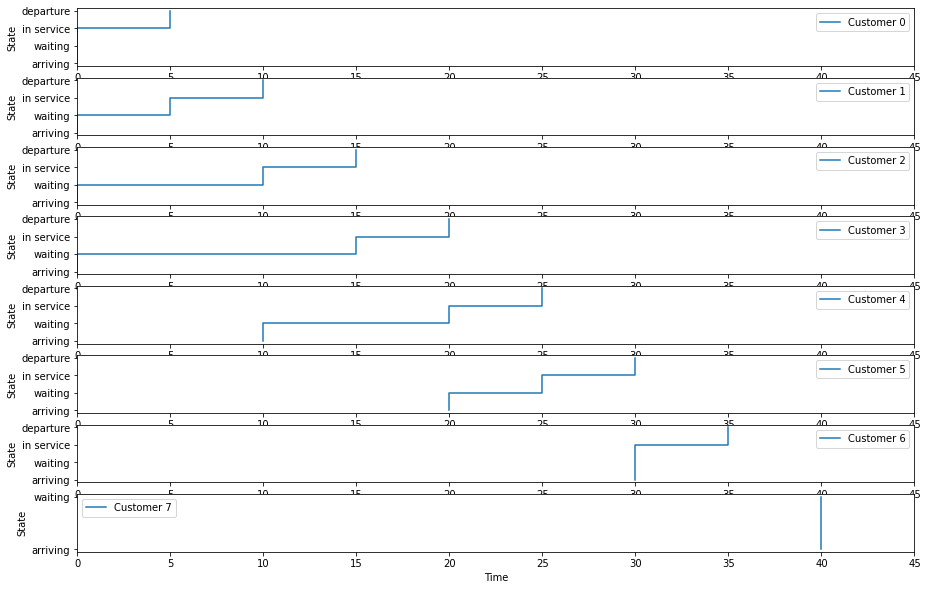

In [4]:
import matplotlib.pyplot as plt
df=pd.DataFrame(events, columns=['time','name','event'])

fig, axs = plt.subplots(len(df['name'].drop_duplicates()),1,figsize=(15,10))
for ax,c in zip(axs.flatten(),df['name'].drop_duplicates()):
    df_c=df.loc[df['name'] == c]
    
    ax.step(df_c['time'],df_c['event'], label=c)
    ax.set_xlabel('Time')
    ax.set_ylabel('State')  
    ax.set_xlim(0, 45)
    ax.legend()

#performance
print(df)
df_w=df.loc[df['event'] == 'waiting']
print('average waiting time: %.2f minutes.' % df_w.mean())

### Challenge 2: (D/D/n)

Now assume that the Bank has more than one service desks. By modifying the code above, model and simulate a Bank queueing system with n=3 service desks.

In [14]:
"""
Bank example.

Covers:

- Waiting for other processes
- Resources: Resource

Scenario:
  A Bank has a limited number of service desks and defines
  a service processes that takes some (random) time.

  Customer processes arrive at the Bank at a random time. If one Service
  desk is available, they start serving the customer and wait for it
  to finish. If not, they wait until they  use one.

"""
import numpy.random as rnd
import simpy
import pandas as pd


RANDOM_SEED = 42
NUM_DESKS = 3  # Number of service desks in the Bank
SERVICETIME = 5      # Minutes it takes to serve a customer
T_INTER = 10       # Create a customer every ~10 minutes
SIM_TIME = 45     # Simulation time in minutes

events=[]

class Bank(object):
    """A Bank has a limited number of service desks (``NUM_DESKS``) to
    serve customers in parallel.

    Customers have to request one of the service desks. When they got one, they
    be served and wait for the agent to finish their request which 
    takes ``SERVICETIME`` minutes).

    """
    def __init__(self, env, num_desks, service_time):
        self.env = env
        self.desk = simpy.Resource(env, num_desks)
        self.serviceTime = service_time

    def service(self, customer):
        """The service processes. It takes a ``customer`` processes and tries
        to serve it."""
       
        
        yield self.env.timeout(SERVICETIME)
        print("The Bank agent is serving %d%% of %s's service request." %
              (rnd.randint(75, 99), customer))
        events.append([env.now,customer,'in service'])

def customer(env, name, bk):
    """The customer process (each customer has a ``name``) arrives at the Bank
    (``bk``) and requests a service desk.

    It then  waits for the agent to finialize his request and
    leaves to never come back ...

    """
    print('%s arrives at the Bank at %.2f.' % (name, env.now))
    events.append([env.now,name,'arriving'])
    with bk.desk.request() as request:
        #waiting for the customer's turn to be served
        yield request
        events.append([env.now,name,'waiting'])
        print('%s is being served %.2f.' % (name, env.now))
        
        yield env.process(bk.service(name))
        events.append([env.now, name,'departure'])
        print('%s leaves the Bank at %.2f.' % (name, env.now))


def setup(env, num_desks, service_time, t_inter):
    """Create a Bank, a number of initial customers and keep creating customers
    approx. every ``t_inter`` minutes."""
    # Create the Bank
    bk = Bank(env, num_desks, service_time)

    #we assume that at the beginning the 4 customers are already in queue
    for i in range(4):
        env.process(customer(env, 'Customer %d' % i, bk))

    # Create more customers while the simulation is running
    #i=0
    while True:
        yield env.timeout(T_INTER)
        i += 1
        env.process(customer(env, 'Customer %d' % i, bk))


# Setup and start the simulation
print('Bank')


# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_DESKS, SERVICETIME, T_INTER))

# Execute!
env.run(until=SIM_TIME)

Bank
Customer 0 arrives at the Bank at 0.00.
Customer 1 arrives at the Bank at 0.00.
Customer 2 arrives at the Bank at 0.00.
Customer 3 arrives at the Bank at 0.00.
Customer 0 is being served 0.00.
Customer 1 is being served 0.00.
Customer 2 is being served 0.00.
The Bank agent is serving 79% of Customer 0's service request.
The Bank agent is serving 76% of Customer 1's service request.
The Bank agent is serving 79% of Customer 2's service request.
Customer 0 leaves the Bank at 5.00.
Customer 1 leaves the Bank at 5.00.
Customer 2 leaves the Bank at 5.00.
Customer 3 is being served 5.00.
Customer 4 arrives at the Bank at 10.00.
The Bank agent is serving 98% of Customer 3's service request.
Customer 4 is being served 10.00.
Customer 3 leaves the Bank at 10.00.
The Bank agent is serving 75% of Customer 4's service request.
Customer 4 leaves the Bank at 15.00.
Customer 5 arrives at the Bank at 20.00.
Customer 5 is being served 20.00.
The Bank agent is serving 77% of Customer 5's service re

### Challenge 3: (M/M/1 and M/M/n)
Now modify your code to model/simulate a Bank queueing system with the following queue type notation:
<ol type="I">
  <li>M/M/1 with arriving rate $\lambda=10$ and departure rate $\mu=5$</li>
  <li>M/M/3</li>
</ol>
Note that M/M/1 means both arriver and departure are Markovian (Exponential)

#### Hint:
The arriver and departure time is modeled using an exponential probability distribution. you can use either:
<ol type="I">
  <li>numpy.random.exponential(scale=rate)</li>
  <li>random.expovariate(1/rate)</li>
</ol>

In [ ]:
#your code here for M/M/1

In [ ]:
#your code here for M/M/3